# Gaussian process

PHYSBO performs Bayesian optimization while running Gaussian process regression.

Therefore, it is possible to run Gaussian process regression given training data, and to predict test data using the trained model.

In this section, the procedure is introduced.


## Preparation of search candidate data

In this tutorial, the problem of finding a stable interface structure for Cu is used as an example. The values that have already been evaluated are used, although the evaluation of the objective function, i.e., the structural relaxation calculation, actually takes on the order of several hours per calculation. For more information on the problem setup, please refer to the following references

- S. Kiyohara, H. Oda, K. Tsuda and T. Mizoguchi, “Acceleration of stable interface structure searching using a kriging approach”, Jpn. J. Appl. Phys. 55, 045502 (2016).


Save the dataset file [s5-210.csv](https://raw.githubusercontent.com/issp-center-dev/PHYSBO/master/examples/grain_bound/data/s5-210.csv) and load dataset from this file as the following:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import physbo


def load_data():
    A =  np.asarray(np.loadtxt('s5-210.csv',skiprows=1, delimiter=',') )
    X = A[:,0:3]
    t  = -A[:,3]
    return X, t

X, t = load_data()
X = physbo.misc.centering( X )


## Defining training data

A randomly selected 10% of the target data will be used as training data, and another randomly selected 10% will be used as test data.

In [2]:
N = len(t)
Ntrain = int(N*0.1)
Ntest = min(int(N*0.1), N-Ntrain)

id_all   = np.random.choice(N, N, replace=False)
id_train  = id_all[0:Ntrain]
id_test = id_all[Ntrain:Ntrain+Ntest]

X_train = X[id_train]
X_test = X[id_test]

t_train = t[id_train]
t_test = t[id_test]

print("Ntrain =", Ntrain)
print("Ntest =", Ntest)

Ntrain = 1798
Ntest = 1798


## Learning and Prediction of Gaussian Processes

The following process is used to learn the Gaussian process and predict the test data.

1. Generate a model of the Gaussian process

2. The model is trained using X_train (parameters of the training data) and t_train (objective function value of the training data).

3. Run predictions on the test data (X_test) using the trained model.

Definition of covariance (Gaussian)

In [3]:
cov = physbo.gp.cov.Gauss( X_train.shape[1],ard = False )

Definition of mean value

In [4]:
mean = physbo.gp.mean.Const()

Definition of likelihood function (Gaussian)

In [5]:
lik = physbo.gp.lik.Gauss()

Generation of a Gaussian Process Model

In [6]:
gp = physbo.gp.Model(lik=lik,mean=mean,cov=cov)
config = physbo.misc.SetConfig()

Learning a Gaussian process model.

In [7]:
gp.fit(X_train, t_train, config)

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 17084.201485122107
50 -th epoch marginal likelihood 4993.497154178499
100 -th epoch marginal likelihood 2567.1861355632855
150 -th epoch marginal likelihood 922.2860779181701
200 -th epoch marginal likelihood -67.88103254796442
250 -th epoch marginal likelihood -780.7034378303829
300 -th epoch marginal likelihood -1240.6604332165407
350 -th epoch marginal likelihood -1422.7429768529548
400 -th epoch marginal likelihood -1522.888170654836
450 -th epoch marginal likelihood -1581.415454892586
500 -th epoch marginal likelihood -1631.1537271689654
Done



Output the parameters in the learned Gaussian process.

In [8]:
gp.print_params()



likelihood parameter =   [-2.8690407]
mean parameter in GP prior:  [-1.06112975]
covariance parameter in GP prior:  [-1.11768488 -2.39796713]




Calculating the mean (predicted value) and variance of the test data

In [9]:
gp.prepare(X_train, t_train)
fmean = gp.get_post_fmean(X_train, X_test)
fcov = gp.get_post_fcov(X_train, X_test)

Results of prediction

In [10]:
fmean

array([-1.00665556, -1.08533365, -1.02534387, ..., -1.06197988,
       -1.06526772, -1.05655287], shape=(1798,))

Results of covariance

In [11]:
fcov

array([0.00079596, 0.00056145, 0.00081618, ..., 0.00084074, 0.00075712,
       0.00071634], shape=(1798,))

Output mean square error of prediction

In [12]:
np.mean((fmean-t_test)**2)

np.float64(0.0037001774310062045)

A simple metric to investigate how important each feature is in the obtained regression model is permutation importance (PI).
In PHYSBO, this can be calculated using the get_permutation_importance function.

In [13]:
pi_mean, pi_std = gp.get_permutation_importance(X_train, t_train, n_perm=100)

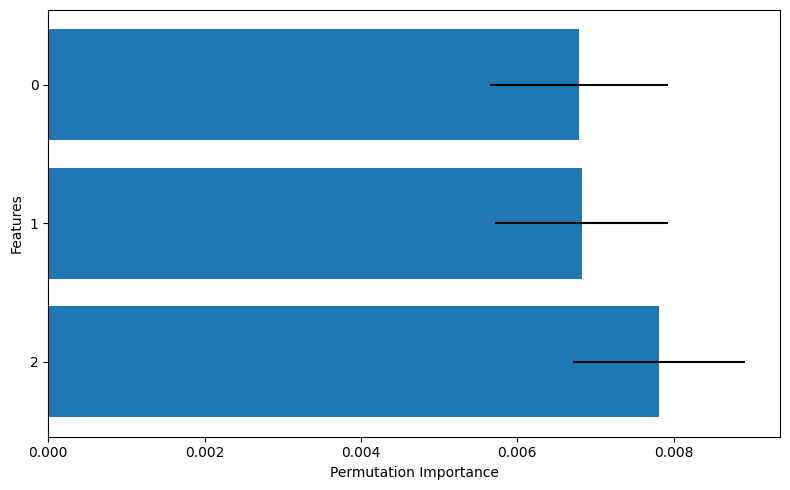

In [14]:
features = list(range(len(pi_mean)))

plt.figure(figsize=(8, 5))
plt.barh(
    features,
    pi_mean,
    xerr=pi_std,
)
plt.gca().invert_yaxis()
plt.yticks(features)
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.tight_layout()
# print("save permutation_importance.pdf")
# plt.savefig("permutation_importance.pdf")

In this graph, the bar chart represents the mean value of the permutation importance (PI), while the line segments indicate the standard deviation. From this, we can interpret that features 1 and 2 appear to be more important compared to feature 0.

Not only gp.model, but policy also has the get_permutation_importance function.
The usage is policy.get_permutation_importance(n_perm).
In the case of policy, PI is calculated based on the stored training data, so unlike model, there is no need to pass the data again.

##  Prediction by trained models

Read the parameters of the trained model as gp_params and make predictions using them.

By storing gp_params and training data (X_train, t_train), prediction by the trained model is possible.

Prepare the learned parameters (must be done immediately after learning)

In [15]:
#Prepare the learned parameters as a 1D array
gp_params =  np.append(np.append(gp.lik.params, gp.prior.mean.params), gp.prior.cov.params)

gp_params

array([-2.8690407 , -1.06112975, -1.11768488, -2.39796713])

Prepare a model similar to the one used for training as gp

In [16]:
#Definition of covariance (Gaussian)
cov = physbo.gp.cov.Gauss( X_train.shape[1],ard = False )

#Definition of mean value
mean = physbo.gp.mean.Const()

#Definition of likelihood function (Gaussian)
lik = physbo.gp.lik.Gauss()

#Generation of a Gaussian Process Model
gp = physbo.gp.Model(lik=lik,mean=mean,cov=cov)


Prepare a model similar to the one used for training as gp

In [17]:
#Input learned parameters into the Gaussian process.
gp.set_params(gp_params)


#Calculate the mean (predicted value) and variance of the test data
gp.prepare(X_train, t_train)
fmean = gp.get_post_fmean(X_train, X_test)
fcov = gp.get_post_fcov(X_train, X_test)

Results of prediction

In [18]:
fmean

array([-1.00665556, -1.08533365, -1.02534387, ..., -1.06197988,
       -1.06526772, -1.05655287], shape=(1798,))

Results of covariance

In [19]:
fcov

array([0.00079596, 0.00056145, 0.00081618, ..., 0.00084074, 0.00075712,
       0.00071634], shape=(1798,))

Output mean square error of prediction

In [20]:
np.mean((fmean-t_test)**2)

np.float64(0.0037001774310062045)

Note: In the example above, we used the same pre-registered X to make predictions.
If you want to make predictions for parameters X_new that is not included in X using the trained model,
you first obtain the mean (X_{mean}) and standard deviation (X_{std}) of the data X and
then normalize X_{new} by (X_{new} - X_{mean}) / X_{std}.
Also, the data format for X is ndarray format.
Therefore, if X_{new} is a single data, it must be transformed to ndarray format.
For example, if X_{new} is a real number, you should replace X_new as
X_new = np.array(X_new).reshape(1)